# Stock market prediction using **time series** & **sentiment** anlysis
# GRIPAUGUST21


## Importing the ibrairies

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
from  tensorflow import keras
import warnings
warnings.filterwarnings('ignore')


## Importing our data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

# headlines dataframe contains textual data on which we're going apply sentiment analysis
headlines_df=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/NLP/india-news-headlines.csv')
#loading the stock price data for Tsla 
stock_df=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/NLP/TSLA(2010-2020).csv",parse_dates=True,index_col='Date')


Mounted at /content/gdrive


In [ ]:
print(headlines_df.shape)
headlines_df.head()

(3424067, 3)


,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [ ]:
headlines_df.tail()

,publish_date,headline_category,headline_text
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...
3424066,20201231,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [ ]:
headlines_df.isna().sum( )
#no need for data imputation

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [ ]:
#Given the fact that our stock_data only spans from 2019 to 2020 we're going to filter all headlines prior to that
print(headlines_df.shape)
headlines_df=headlines_df[headlines_df['publish_date']>20100629]
headlines_df.head()

(3424067, 3)


,publish_date,headline_category,headline_text
936718,20100630,entertainment.hindi.bollywood,SRK cut to size!
936719,20100630,tech.how-to,How to boot up Windows XP
936720,20100630,home.environment.developmental-issues,Green power an easy win for Australia-scientists
936721,20100630,entertainment.hindi.bollywood,I don't wear lip gloss: Imran
936722,20100630,tv.news.hindi,It's Marathi manoos on TV!


In [ ]:
#Set the publish_date column as the index and formating it to a proper date-time format
headlines_df["publish_date"]=headlines_df['publish_date'].astype(str)
headlines_df["publish_date"]=headlines_df["publish_date"].apply(lambda date: date[0:4]+"-"+date[4:6]+"-"+date[6:8])
headlines_df['publish_date']=pd.to_datetime(headlines_df['publish_date']).dt.normalize()

In [ ]:
headlines_df.head()

,publish_date,headline_category,headline_text
936718,2010-06-30,entertainment.hindi.bollywood,SRK cut to size!
936719,2010-06-30,tech.how-to,How to boot up Windows XP
936720,2010-06-30,home.environment.developmental-issues,Green power an easy win for Australia-scientists
936721,2010-06-30,entertainment.hindi.bollywood,I don't wear lip gloss: Imran
936722,2010-06-30,tv.news.hindi,It's Marathi manoos on TV!


In [ ]:
#filter the headine_category column 
headlines_df=headlines_df.drop('headline_category',axis=1)
headlines_df.head()

,publish_date,headline_text
936718,2010-06-30,SRK cut to size!
936719,2010-06-30,How to boot up Windows XP
936720,2010-06-30,Green power an easy win for Australia-scientists
936721,2010-06-30,I don't wear lip gloss: Imran
936722,2010-06-30,It's Marathi manoos on TV!


In [ ]:
#grouping the headlines according to date
headlines_df = headlines_df.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
headlines_df.head()

,publish_date,headline_text
0,2010-06-30,"SRK cut to size!,How to boot up Windows XP,Gre..."
1,2010-07-01,"Hotel Hollywood; a must watch!,Kat's not a cry..."
2,2010-07-02,"Read between the 'signs',Race row threatens to..."
3,2010-07-03,"Bee sting can help treat arthritis,Graves vand..."
4,2010-07-04,"Tips to make your browser secure,Review: Sony ..."


In [ ]:
headlines_df.set_index('publish_date',inplace=True)
headlines_df.head()

,headline_text
publish_date,
2010-06-30,"SRK cut to size!,How to boot up Windows XP,Gre..."
2010-07-01,"Hotel Hollywood; a must watch!,Kat's not a cry..."
2010-07-02,"Read between the 'signs',Race row threatens to..."
2010-07-03,"Bee sting can help treat arthritis,Graves vand..."
2010-07-04,"Tips to make your browser secure,Review: Sony ..."


In [ ]:
headlines_df.shape

(3838, 1)

In [ ]:
headlines_df.tail()

,headline_text
publish_date,
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...
2020-12-30,Numerology Readings 30 December 2020: Predicti...
2020-12-31,Horoscope Today; 31 December 2020: Check astro...


In [ ]:
print(stock_df.shape)
stock_df.head()

(2645, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500


In [ ]:
stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,632.200012,651.500000,622.570007,645.979980,645.979980,33173000
2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600
2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600
2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800
2020-12-30,672.000000,696.599976,668.359985,694.780029,694.780029,42846000


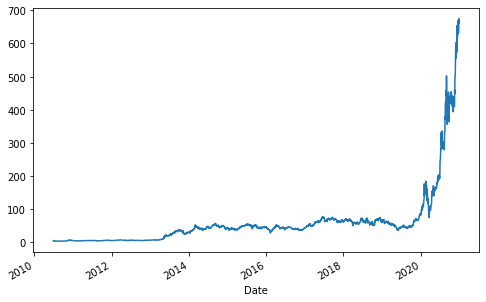

In [ ]:
plt.figure(figsize=(8,5))
stock_df["Open"].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f756d826b10>,
      dtype=object)

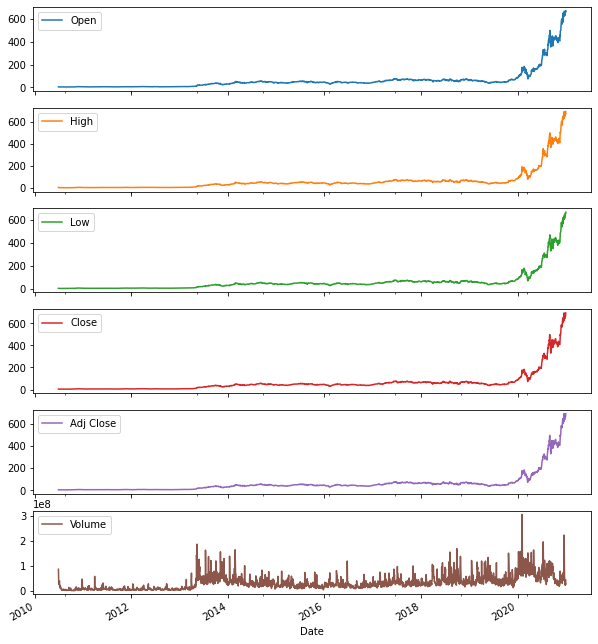

In [ ]:
stock_df.plot(subplots=True,figsize=(10,12))

In [ ]:
#Combining the 2 dataframes
stock_data=pd.concat([stock_df,headlines_df],axis=1)

#dropping null values
stock_data.dropna(axis=0,inplace=True)

print(stock_data.shape)
stock_data.head()

(2645, 7)


,Open,High,Low,Close,Adj Close,Volume,headline_text
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500.0,"SRK cut to size!,How to boot up Windows XP,Gre..."
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,"Hotel Hollywood; a must watch!,Kat's not a cry..."
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,"Read between the 'signs',Race row threatens to..."
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,"Burger Shurger Hai Rabba!,Personality can pred..."
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,"Tagore's abode in Shillong demolished,22 train..."


### Preparing headline_text for sentiment analysis

In [ ]:
#First start with lowercase()
stock_data['headline_text']=stock_data['headline_text'].apply(lambda x:x.lower())
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,headline_text
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500.0,"srk cut to size!,how to boot up windows xp,gre..."
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,"hotel hollywood; a must watch!,kat's not a cry..."
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,"read between the 'signs',race row threatens to..."
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,"burger shurger hai rabba!,personality can pred..."
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,"tagore's abode in shillong demolished,22 train..."


### Importing librairies for NLP

In [ ]:
import nltk
import re #regex
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
stock_copy=stock_data.copy()
print(stock_copy['headline_text'][0])
stock_copy

srk cut to size!,how to boot up windows xp,green power an easy win for australia-scientists,i don't wear lip gloss: imran,it's marathi manoos on tv!,time to bury the hatchet,akki to endorse canada in india,diviya's fun-filled party!,bollywood beauties get arty,pallavi's hubby isn't directing her,meet the boy-next-door!,divyanka; sharad 'friends' no more?,sonali has no time for virtual world,snigdhaa wants shorr!,kishori's takes a break!,archana taide's tattoo tales,the countdown begins,arjan's bloody experience,golmaal 3's footy fever!,nikhil to play a commentator in patiala,anushka is getting hot,colombo bonding salman; sanjay,sonam's sis doesn't like ranbir!,genelia in a genial mood,selva starts a 'quickie'!,g v prakash: breaking boundaries,tapasee's lady luck!,chennai's blaze of glory!,all about good cholesterol!,in control,english hatao,for the first time we have the power to eradicate a cancer,for the first time we have the power to eradicate a cancer,looking beyond the hype,safeg

,Open,High,Low,Close,Adj Close,Volume,headline_text
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500.0,"srk cut to size!,how to boot up windows xp,gre..."
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000.0,"hotel hollywood; a must watch!,kat's not a cry..."
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000.0,"read between the 'signs',race row threatens to..."
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500.0,"burger shurger hai rabba!,personality can pred..."
2010-07-07,3.280000,3.326000,2.996000,3.160000,3.160000,34608500.0,"tagore's abode in shillong demolished,22 train..."
...,...,...,...,...,...,...,...
2020-12-23,632.200012,651.500000,622.570007,645.979980,645.979980,33173000.0,"sawmill in makarpura gidc gutted; none hurt,ci..."
2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600.0,how to set the mood for sex during cold winter...
2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600.0,horoscope today; 28 december 2020: check astro...
2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800.0,man recovers charred remains of 'thief' from h...


In [ ]:
# #Tokenization
# def tokenize(text):
#   text=nltk.sent_tokenize(text)
#   return text


#### Tokenizing isn't working check it later

In [ ]:
# # stock_copy['headline_text_tokenized']=stock_copy["headline_text"].apply(tokenize)
# # print(stock_copy['headline_text_tokenized'][0])
# # print(len(stock_copy['headline_text_tokenized'][0]))
# print(len(nltk.sent_tokenize(stock_copy['headline_text'][0])))


In [ ]:
# #Lemmatization and stop words elimination
# lemmatizer=WordNetLemmatizer()
# def lemmatizing(text):
#   words = nltk.word_tokenize(text)
#   words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
#   return words
# stock_copy["lemmatized"]=stock_copy["headline_text"].apply(lemmatizing)
# stock_copy

In [ ]:
#Stemming
#we won't proceed with the stemming because we need actual words

### sentiment analysis
we will be using the VADER ( Valence Aware Dictionary for Sentiment Reasoning) which is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories:

-1 negative

-2 neutral

-3 positive

-4 compound (computed by normalizing the scores above)

For further information see article [https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664]

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_copy['compound'] = stock_copy['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_copy['negative'] = stock_copy['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_copy['neutral'] = stock_copy['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_copy['positive'] = stock_copy['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_copy.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Open,High,Low,Close,Adj Close,Volume,headline_text,compound,negative,neutral,positive
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500.0,"srk cut to size!,how to boot up windows xp,gre...",-0.9985,0.123,0.805,0.072
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,"hotel hollywood; a must watch!,kat's not a cry...",-0.9999,0.170,0.753,0.077
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,"read between the 'signs',race row threatens to...",-0.9998,0.155,0.768,0.077
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,"burger shurger hai rabba!,personality can pred...",-0.9997,0.129,0.814,0.057
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,"tagore's abode in shillong demolished,22 train...",-0.9999,0.153,0.782,0.065


In [ ]:
stock_copy1=stock_copy.copy()
stock_copy2=stock_copy.copy()

In [ ]:
stock_copy1.drop('headline_text',axis=1,inplace=True)

In [ ]:
stock_copy1

,Open,High,Low,Close,Adj Close,Volume,compound,negative,neutral,positive
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500.0,-0.9985,0.123,0.805,0.072
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000.0,-0.9999,0.170,0.753,0.077
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000.0,-0.9998,0.155,0.768,0.077
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500.0,-0.9997,0.129,0.814,0.057
2010-07-07,3.280000,3.326000,2.996000,3.160000,3.160000,34608500.0,-0.9999,0.153,0.782,0.065
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,632.200012,651.500000,622.570007,645.979980,645.979980,33173000.0,-0.9995,0.117,0.805,0.079
2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600.0,-0.9965,0.080,0.857,0.063
2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600.0,-0.9997,0.124,0.793,0.083
2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800.0,-0.9997,0.133,0.778,0.089


In [ ]:
def split(data,split_perc=0.8):
  train_data=data[:int(len(data)*split_perc)]
  test_data=data[int(len(data)*split_perc):]
  print("number of rows in training data:", train_data.shape[0])
  print("number of rows in test Data:", test_data.shape[0])
  return train_data,test_data


In [ ]:
train_data,test_data=split(stock_copy1)

number of rows in training data: 2116
number of rows in test Data: 529


In [ ]:
train_data

,Open,High,Low,Close,Adj Close,Volume,compound,negative,neutral,positive
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500.0,-0.9985,0.123,0.805,0.072
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000.0,-0.9999,0.170,0.753,0.077
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000.0,-0.9998,0.155,0.768,0.077
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500.0,-0.9997,0.129,0.814,0.057
2010-07-07,3.280000,3.326000,2.996000,3.160000,3.160000,34608500.0,-0.9999,0.153,0.782,0.065
...,...,...,...,...,...,...,...,...,...,...
2018-11-15,68.466003,69.716003,67.807999,69.688004,69.688004,23128500.0,-0.9999,0.140,0.774,0.086
2018-11-16,69.038002,71.139999,69.024002,70.862000,70.862000,36031000.0,-1.0000,0.147,0.781,0.072
2018-11-19,71.267998,73.349998,70.575996,70.694000,70.694000,48544500.0,-0.9999,0.144,0.775,0.081
2018-11-20,68.349998,69.959999,66.709999,69.498001,69.498001,40023500.0,-0.9999,0.128,0.791,0.081


In [ ]:
test_data[7:]

,Open,High,Low,Close,Adj Close,Volume,compound,negative,neutral,positive
2018-12-04,1.624274,1.683328,1.642815,1.656350,1.656350,0.773147,-0.198844,-0.382535,0.883528,-0.936813
2018-12-06,1.623924,1.672114,1.631776,1.685775,1.685775,0.636223,-0.198293,-0.672222,1.022208,-0.786815
2018-12-07,1.737684,1.776575,1.693112,1.641199,1.641199,1.447225,-0.199119,0.834151,0.282581,-1.536804
2018-12-10,1.658866,1.660038,1.652785,1.704079,1.704079,0.364540,-0.198844,0.370652,0.005221,-0.561818
2018-12-11,1.745653,1.713433,1.716079,1.718178,1.718178,0.297183,-0.198018,-1.135721,1.253341,-0.561818
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,26.188652,26.602094,26.220313,26.792559,26.792559,0.369205,-0.197743,-0.730159,1.160888,-0.861814
2020-12-24,26.661118,27.231357,27.040646,27.483977,27.483977,-0.086506,-0.189485,-2.873844,3.564673,-2.061796
2020-12-28,28.041303,27.891672,27.921958,27.568050,27.568050,0.329661,-0.198293,-0.324597,0.606168,-0.561818
2020-12-29,27.449733,27.395681,27.663797,27.668762,27.668762,-0.084507,-0.198293,0.196839,-0.087232,-0.111825


In [ ]:
#choose the rolling window+ steps to predict, choose the scaling method
#try xgboost also
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler=scaler.fit(train_data)
train_data[train_data.columns]=scaler.transform(train_data)
test_data[test_data.columns]=scaler.transform(test_data)

In [ ]:
train_data.head()

,Open,High,Low,Close,Adj Close,Volume,compound,negative,neutral,positive
2010-06-30,-1.267981,-1.234480,-1.283322,-1.285083,-1.285083,2.701938,-0.194990,-0.382535,1.160888,-1.386806
2010-07-01,-1.274900,-1.273296,-1.310295,-1.301460,-1.301460,0.719407,-0.198844,2.340524,-1.242898,-1.011812
2010-07-02,-1.292415,-1.297622,-1.324183,-1.325631,-1.325631,0.038764,-0.198568,1.471462,-0.549499,-1.011812
2010-07-06,-1.318687,-1.324362,-1.349821,-1.352692,-1.352692,0.420557,-0.198293,-0.034910,1.576927,-2.511790
2010-07-07,-1.350214,-1.353431,-1.357388,-1.355407,-1.355407,0.432671,-0.198844,1.355588,0.097675,-1.911798


In [ ]:
test_data

,Open,High,Low,Close,Adj Close,Volume,compound,negative,neutral,positive
2018-11-23,1.434236,1.414372,1.407353,1.359728,1.359728,-0.168413,-0.198293,-0.846034,1.207114,-0.861814
2018-11-26,1.352353,1.489590,1.402456,1.536369,1.536369,0.669293,-0.198844,0.428589,-0.457045,0.188171
2018-11-27,1.484154,1.495973,1.495929,1.518154,1.518154,0.308126,-0.198844,0.080965,0.375034,-0.711816
2018-11-28,1.536173,1.507359,1.555662,1.552746,1.552746,-0.184992,-0.198844,1.065901,-0.595725,-0.486819
2018-11-29,1.545019,1.500631,1.531983,1.494070,1.494070,-0.416420,-0.198568,0.080965,-0.087232,0.038173
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,26.188652,26.602094,26.220313,26.792559,26.792559,0.369205,-0.197743,-0.730159,1.160888,-0.861814
2020-12-24,26.661118,27.231357,27.040646,27.483977,27.483977,-0.086506,-0.189485,-2.873844,3.564673,-2.061796
2020-12-28,28.041303,27.891672,27.921958,27.568050,27.568050,0.329661,-0.198293,-0.324597,0.606168,-0.561818
2020-12-29,27.449733,27.395681,27.663797,27.668762,27.668762,-0.084507,-0.198293,0.196839,-0.087232,-0.111825


In [ ]:
#n_future: steps to predict in the future based on past days
#n_past: number of past days to consider when making predictions
def reformat(df,n_future=1,n_past=7):
  X_train=[]
  y_train=[]
  for i in range(n_past,len(df)-n_future+1):
    X_train.append(df.iloc[i-n_past:i,0:df.shape[1]])
    y_train.append(df.iloc[i+n_future-1:i+n_future,3])
  return np.array(X_train),np.array(y_train)

In [ ]:
#test_data should be transformed with scaler (careful only transformes and not fitted)
X_train,y_train=reformat(train_data)
X_test,y_test=reformat(test_data)

In [ ]:
print(f"X_train.shape={X_train.shape}")
print(f"y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}")
print(f"y_test.shape={y_test.shape}")

X_train.shape=(2109, 7, 10)
y_train.shape=(2109, 1)
X_test.shape=(522, 7, 10)
y_test.shape=(522, 1)


In [ ]:
print(y_train[:10])
print(y_test[:10])

[[-1.34445975]
 [-1.33491391]
 [-1.32002591]
 [-1.31958802]
 [-1.31301979]
 [-1.30189757]
 [-1.31599739]
 [-1.316698  ]
 [-1.30986703]
 [-1.30732731]]
[[1.65634951]
 [1.68577513]
 [1.64119878]
 [1.70407858]
 [1.71817831]
 [1.71677722]
 [1.80601777]
 [1.70898282]
 [1.55756303]
 [1.45781339]]


- as you can clearly see the test values have been scaled using the params of scaler when it was fitted on train_data 

In [ ]:
#creating a base model 
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(32, activation='relu', return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 64)             19200     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
60/60 [==============================] - 4s 33ms/step - loss: 0.2019 - val_loss: 0.0339
Epoch 2/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0345 - val_loss: 0.0288
Epoch 3/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0306 - val_loss: 0.0460
Epoch 4/10
60/60 [==============================] - 2s 28ms/step - loss: 0.0281 - val_loss: 0.0451
Epoch 5/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0292 - val_loss: 0.0255
Epoch 6/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0266 - val_loss: 0.0279
Epoch 7/10
60/60 [==============================] - 2s 29ms/step - loss: 0.0280 - val_loss: 0.0247
Epoch 8/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0260 - val_loss: 0.0217
Epoch 9/10
60/60 [==============================] - 2s 27ms/step - loss: 0.0264 - val_loss: 0.0214
Epoch 10/10
60/60 [==============================] - 2s 28ms/step - loss: 0.0238 - val_loss: 0.0266


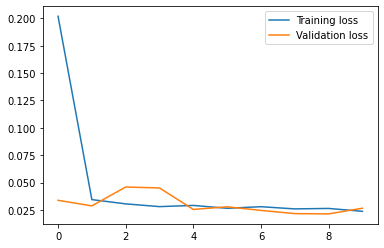

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Evaluation

In [ ]:
#first we use .predict() to generate our predictions and then scale them back to their initial values 
predictions = model.predict(X_test) 
prediction_copies = np.repeat(predictions, train_data.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
print(len(y_pred))
print(y_pred[-5:])

522
[141.0775  134.22154 140.81422 147.28107 141.92505]


In [ ]:
train_loss=model.evaluate(X_train,y_train)
test_loss=model.evaluate(X_test,y_test)
print("train_loss",np.round(train_loss,4))
print("test_loss",np.round(test_loss,4))

17/17 [==============================] - 0s 6ms/step - loss: 45.2394
train_loss 0.0074
test_loss 45.2394


In [ ]:
y_test_copies=np.repeat(y_test, train_data.shape[1], axis=-1)
actual_values=scaler.inverse_transform(y_test_copies)[:,0]
actual_values

array([ 71.94252655,  72.6145354 ,  71.59652097,  73.03254114,
        73.35454434,  73.32254683,  75.36058172,  73.14454195,
        69.68648614,  67.40844937,  66.59644026,  63.07838147,
        63.95639464,  59.08031594,  65.22041805,  63.22838589,
        66.77644316,  66.56243571,  62.02636249,  60.07433198,
        63.54038693,  66.99444168,  67.07244594,  67.70845721,
        68.99648   ,  69.45448739,  66.88243987,  68.88847725,
        69.21247948,  69.46448255,  60.45433912,  59.78632833,
        57.52029376,  58.30430241,  59.41032327,  59.27832113,
        59.49432462,  61.75636213,  61.40635348,  62.44437224,
        62.58037243,  64.27239775,  63.44638741,  61.50435507,
        61.16235055,  62.57037427,  62.36436995,  61.6363572 ,
        60.75634599,  61.57835726,  61.13034803,  60.51434109,
        58.24830151,  58.94431574,  59.75632985,  59.57432391,
        62.95038141,  63.978398  ,  58.960315  ,  57.07428356,
        55.31025509,  55.25025612,  55.32025725,  56.83

In [ ]:
len(actual_values)

522

In [ ]:
import sklearn
mse = sklearn.metrics.mean_squared_error(actual_values, y_pred)

In [ ]:
mse

23594.770120314868

In [ ]:
forecast_dates=test_data[7:].index.strftime('%m/%d/%Y').values
print(len(forecast_dates))

522


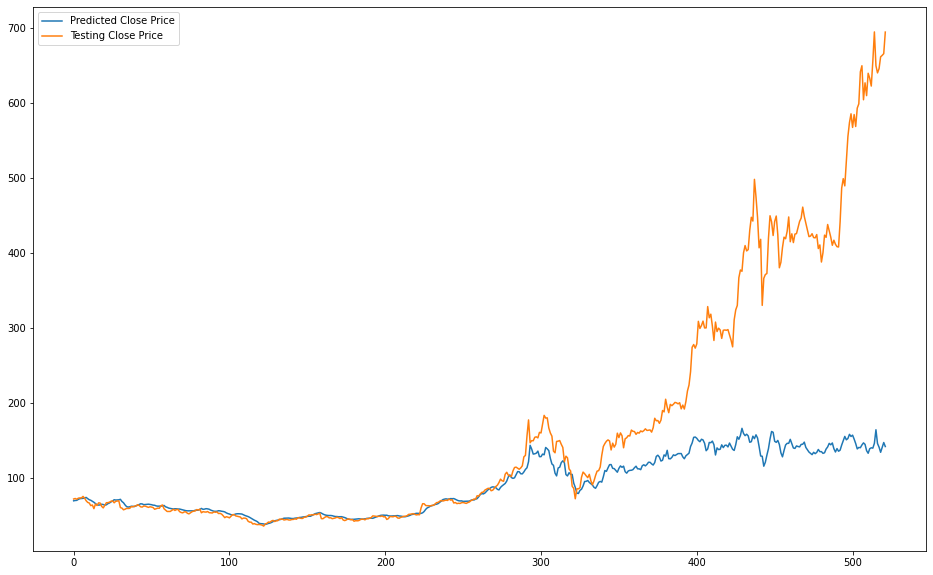

In [ ]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(y_pred, label="Predicted Close Price")
plt.plot(actual_values, label="Testing Close Price")
# plt.xticks(rotation=90)
plt.legend()

## Change Architecture try tanh activation function add another layer, fine tune using sklearn keras wrappers